**Importing dependencies**

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import os
from os.path import exists, join
import shutil
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D,  Activation, MaxPooling2D, Dropout
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from keras.callbacks import TensorBoard,ModelCheckpoint
# Load the TensorBoard notebook extension
%reload_ext tensorboard

**Mounting google drive to get data**

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

#changing directory to working directory
os.chdir("/content/drive/My Drive/dtoxd_nsfw/Data")

Mounted at /content/drive


**Preparing data (Data pre-processing)**

In [ ]:
#create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,	width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0,width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
#prepare iterators
train_it = train_datagen.flow_from_directory('/content/drive/My Drive/dtoxd_nsfw/Data/training',class_mode='binary', batch_size=32, target_size=(224, 224))
val_it = val_datagen.flow_from_directory('/content/drive/My Drive/dtoxd_nsfw/Data/validation',class_mode='binary', batch_size=32, target_size=(224, 224))
#load and iterate test dataset
test_it = test_datagen.flow_from_directory('/content/drive/My Drive/dtoxd_nsfw/Data/testing', class_mode='binary', batch_size=32, target_size=(224, 224))

Found 65337 images belonging to 2 classes.
Found 7779 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


**Model**

In [ ]:
#transfer learning using MobileNet_V2
model_mobilenet_v2 = tf.keras.applications.MobileNetV2(input_shape=(224,224,3) ,include_top=False, weights='imagenet')

model = tf.keras.Sequential()

#freezing mobilenet_v2 layers (saving its original weights)
model_mobilenet_v2.trainable = False
#copy mobilenet_v2 layers into our model
model.add(model_mobilenet_v2)
#Adding our own layers
model.add(tf.keras.layers.GlobalAveragePooling2D()) 
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1 , activation='sigmoid'))
model.compile(optimizer= 'Adam', metrics=['accuracy'], loss='binary_crossentropy')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,422,081
Trainable params: 164,097
Non-trainable params: 2,257,984
_________________________________________________________________


**Training**

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)
#train/validate model
history = model.fit(train_it, epochs=10, validation_data=val_it , verbose=1,callbacks = [early_stop])

Epoch 1/10
1026/2042 [==============>...............] - ETA: 2:25:38 - loss: 0.2014 - accuracy: 0.9196

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (138012160 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


2042/2042 [==============================] - 19766s 10s/step - loss: 0.1804 - accuracy: 0.9293 - val_loss: 0.2816 - val_accuracy: 0.8961
Epoch 2/10
2042/2042 [==============================] - 911s 446ms/step - loss: 0.1301 - accuracy: 0.9510 - val_loss: 0.2445 - val_accuracy: 0.9017
Epoch 3/10
2042/2042 [==============================] - 915s 448ms/step - loss: 0.1216 - accuracy: 0.9546 - val_loss: 0.2393 - val_accuracy: 0.9077
Epoch 4/10
2042/2042 [==============================] - 910s 446ms/step - loss: 0.1148 - accuracy: 0.9577 - val_loss: 0.2520 - val_accuracy: 0.9085
Epoch 5/10
2042/2042 [==============================] - 910s 446ms/step - loss: 0.1110 - accuracy: 0.9586 - val_loss: 0.2449 - val_accuracy: 0.9080
Epoch 6/10
2042/2042 [==============================] - 910s 445ms/step - loss: 0.1089 - accuracy: 0.9587 - val_loss: 0.2290 - val_accuracy: 0.9128
Epoch 7/10
2042/2042 [==============================] - 910s 446ms/step - loss: 0.1079 - accuracy: 0.9600 - val_loss: 0.252

**Visualization**

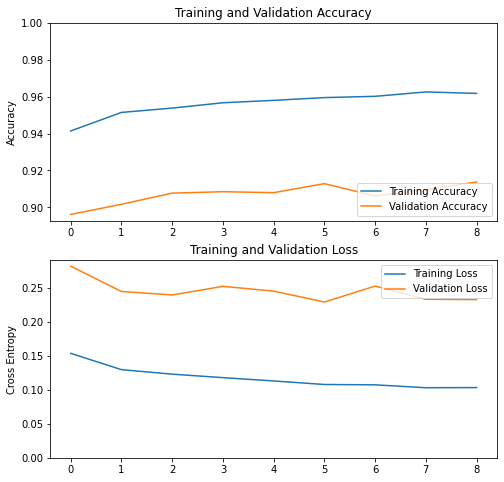

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

**Prediction**

In [ ]:
class_names = sorted(train_it.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print (class_names)
img = cv2.imread('/content/drive/My Drive/dtoxd_nsfw/Data/training/safe/2.jpeg')
img = cv2.resize(img,(224,224))
img = np.reshape(img,[1,224,224,3])
prediction = model.predict(img)
print(prediction)
predicted_id = np.argmax(prediction, axis=-1)
predicted_label_batch = class_names[predicted_id]
print (predicted_label_batch)

['Explicit' 'Safe']
[[0.9972445]]
['Explicit']


**Save the model and convert it to TF lite**

In [ ]:
#Saving the model
mymodel = tf.keras.models.save_model(model, '/content/drive/My Drive/dtoxd_nsfw', overwrite=True, include_optimizer=True)

#Tf Lite
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model) 
tflite_model = converter.convert()

# Save the model
with open('dtoxd_model.tflite', 'wb') as f:
  f.write(tflite_model)